# LBPM Color Model - Fractional Flow Protocol

**Author Contact:** <br>
Email: [jamesmcclure@lbpm-sim.org](mailto:jamesmcclure@lbpm-sim.org)

Generate relative permeability curves based on simulated fractional flow curves

( For full documentation see:  http://lbpm-sim.org/userGuide/models/color/index.html )

Protocols are supported for relevant SCAL workflows
* fractional flow protocol (http://lbpm-sim.org/userGuide/models/color/protocols/fractionalFlow.html)
* core-flooding protocol (http://lbpm-sim.org/userGuide/models/color/protocols/coreFlooding.html)
* centifuge protocl (http://lbpm-sim.org/userGuide/models/color/protocols/centrifuge.html)

A wide range of options are supported (e.g. providing wettability maps)

Internal analysis capabilities: http://lbpm-sim.org/userGuide/models/color/index.html#analysis-capabilities

Further reading: https://link.springer.com/article/10.1007/s10596-020-10028-9

LBPM software package:  https://github.com/opm/lbpm

In [1]:
# read csv file and plot data
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Image processsing
import skimage

# Image visualization
import tifffile

# Other utility functions
import os
# TODO: be smarter about changing directory
import glob
#import src.utils
# if glob.glob('data/*.tif') == []:
#     src.utils.get_datafiles()
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display, clear_output

import sys
sys.path.append('../')
import src.utils

# Input Paramaters

Key sections of the input file are
* `Domain` - provides information about the input image and domain decomposition (not model specific)
* `Color` - provides input parameters for the color model
* `Analysis` - specify options for the internal analysis framework
* `Visualization` - specify visualization options
* `FlowAdaptor` - internal framework to modify fluid states for fractional flow

```
Domain {
   Filename = "segmented_bead_pack_512.ubc.morphdrain.raw"
   voxel_length = 17.4
   N = 256, 256, 256
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1, 2 
   WriteValues = 0, 1, 2 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.3
}
Color {
   ComponentLabels = 0, 
   ComponentAffinity = 0.9, 
   WettingConvention = "SCAL"
   protocol = "fractional flow"
   rhoA = 1.0
   rhoB = 1.0
   tauA = 0.7
   tauB = 0.7
   alpha = 0.008
   beta = 0.95
   F = 0.0, 0.0, 1e-06
   capillary_number = 1e-04
   timestepMax = 10000000
}
Analysis {
   subphase_analysis_interval= 5000
   analysis_interval = 1000
   restart_interval = 10000000
   restart_file = "Restart"
}
Visualization {
   write_silo = true
   save_8bit_raw = true
   save_phase_field = true
   save_pressure = false
   save_velocity = false
   visualization_interval = 5000000
}
FlowAdaptor {
   min_steady_timesteps = 50000
   max_steady_timesteps = 60000
}
MRT { 
   timestepMax = 20000
   tau = 0.7
   F = 0.0, 0.0, 1.0e-5
   tolerance = 0.01
}
```

# Input Image

Specify the position of rock and fluids in 8-bit binary file

* "Oil" should be labeled as `1`
* "Water" should be labeled as `2`
* "Solid" should be a non-positive label (`0, -1, -2, ...)`

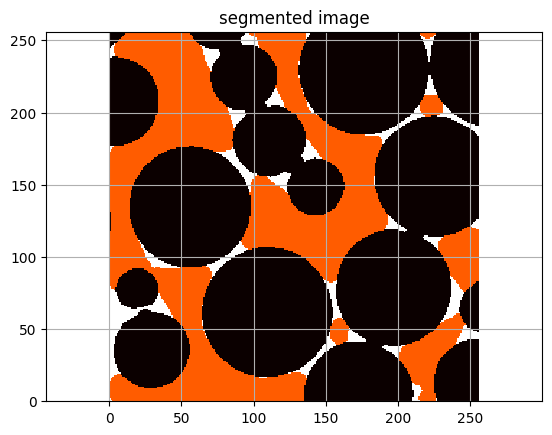

In [2]:
def PlotMorphImage(input_file) :
    ID=tifffile.imread(input_file)
    plt.figure(2)
    plt.title('segmented image')
    plt.pcolormesh(ID[100,:,:],cmap='hot')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

PlotMorphImage("../data/morphdrain/segmented_bead_pack_256_morphdrain.tif")

# Job submission on Lonestar 6

## Get the simulation cases

Go to your work directory
`cd $WORK`

Copy the archive
`cp /home1/02453/mcclurej/ls6/DRP24_Color.tar.gz $WORK`

Open the archive
`tar -xzvf DRP24_Color.tar.gz`

## Submit the job

Each simulation case has it's own directory. Navigate to any sub-directory to run a job

`sbatch Color.A100.ls6.slurm`

## Check that it is running

`squeue -u <username>`


## Check that it is producing output 

Analysis will be performed every 1000 timesteps and written to the space-delimited csv file ``

`awk '{print $1, $2, $3}' timelog.csv`


# Analysis framework 

* Flow adaptor changes the saturation after steady-state points are simulated 
* Generates a full relperm curve in a single simulation
* Results can be plotted before a simulation finishes if you like!

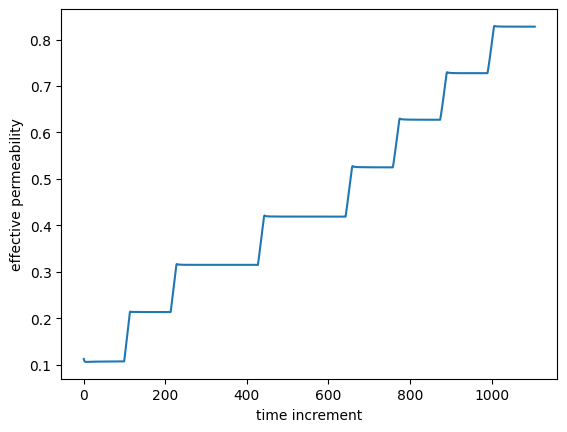

In [6]:
D=pd.read_csv("../lbpm/relperm/lrc32/timelog.csv",sep=" ")

plt.figure()
plt.plot(D['sw'])
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.show()


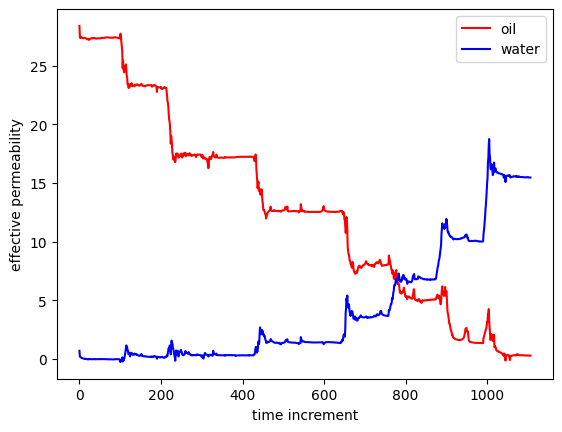

In [4]:
plt.figure()
plt.plot(D['krn'], c='r', label='oil')
plt.plot(D['krw'], c='b', label='water')
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.legend()
plt.show()

# Relative permeability curve

Relative permeability curve is generated for steady points and logged to `SCAL.csv`

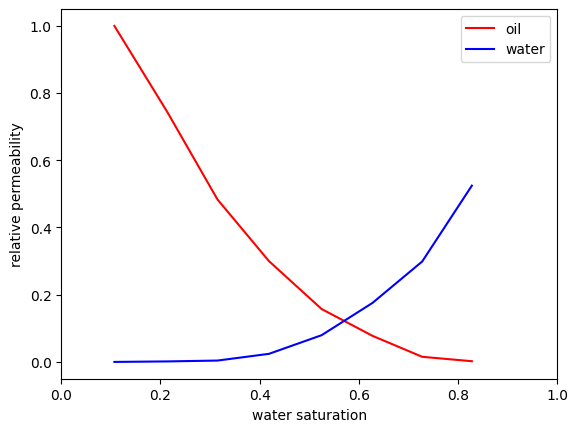

In [7]:
SCAL=pd.read_csv("../lbpm/relperm/lrc32/SCAL.csv",sep=" ")

# Scale the curve to the far LHS value
k=SCAL['eff.perm.oil.upper.bound'][0]
krn=SCAL['eff.perm.oil.upper.bound']/k
krw=SCAL['eff.perm.water.upper.bound']/k

plt.figure()
plt.plot(SCAL['sat.water'],krn, c='r', label='oil')
plt.plot(SCAL['sat.water'],krw, c='b', label='water')
plt.xlabel('water saturation')
plt.ylabel('relative permeability')
ax = plt.gca()
ax.set_xlim([0,1])
plt.legend()
plt.show()

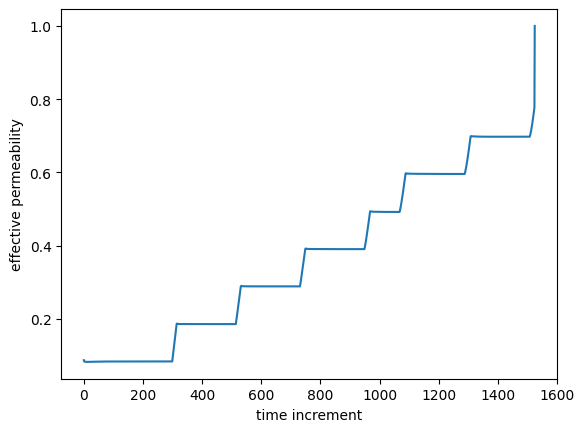

In [8]:
D=pd.read_csv("../lbpm/relperm/beadpack/timelog.csv",sep=" ")

plt.figure()
plt.plot(D['sw'])
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.show()

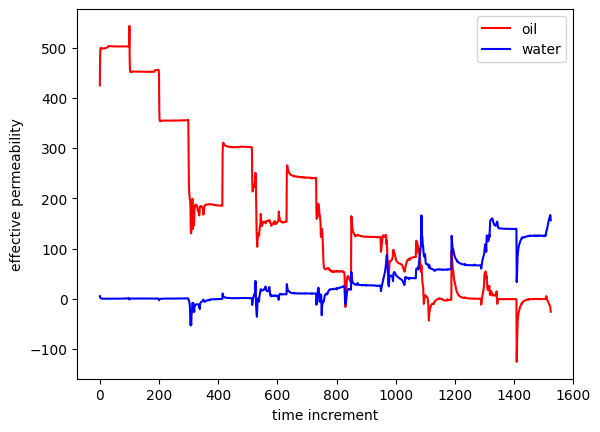

In [7]:
plt.figure()
plt.plot(D['krn'], c='r', label='oil')
plt.plot(D['krw'], c='b', label='water')
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.legend()
plt.show()

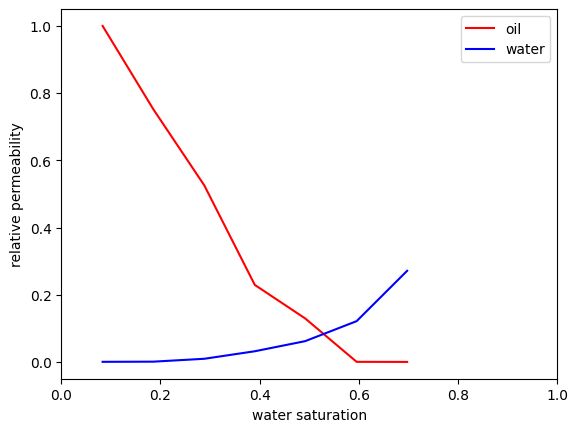

In [9]:
SCAL=pd.read_csv("../lbpm/relperm/beadpack/SCAL.csv",sep=" ")

# Scale the curve to the far LHS value
k=SCAL['eff.perm.oil.upper.bound'][0]
krn=SCAL['eff.perm.oil.upper.bound']/k
krw=SCAL['eff.perm.water.upper.bound']/k

plt.figure()
plt.plot(SCAL['sat.water'],krn, c='r', label='oil')
plt.plot(SCAL['sat.water'],krw, c='b', label='water')
plt.xlabel('water saturation')
plt.ylabel('relative permeability')
ax = plt.gca()
ax.set_xlim([0,1])
plt.legend()
plt.show()


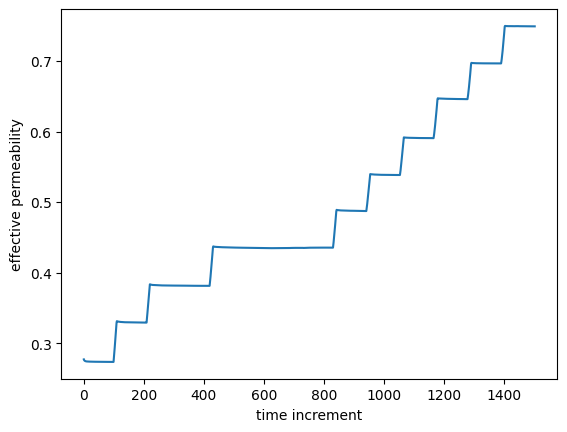

In [11]:
D=pd.read_csv("../lbpm/relperm/gambier/timelog.csv",sep=" ")

plt.figure()
plt.plot(D['sw'])
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.show()

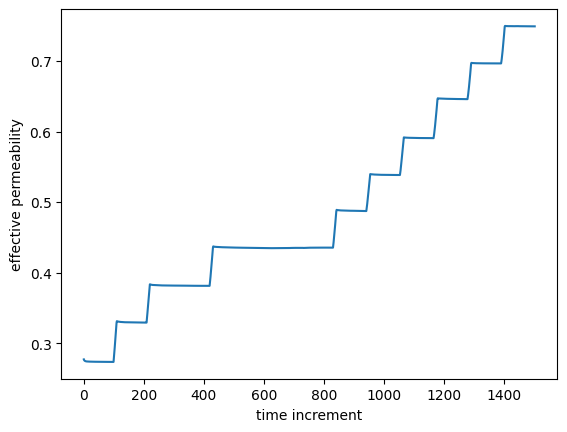

In [12]:
D=pd.read_csv("../lbpm/relperm/gambier/timelog.csv",sep=" ")

plt.figure()
plt.plot(D['sw'])
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.show()

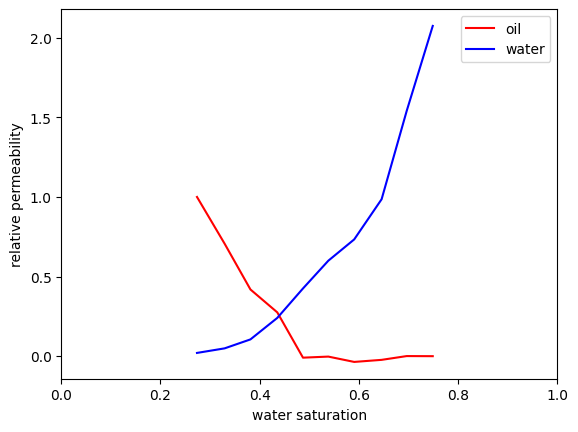

In [13]:
SCAL=pd.read_csv("../lbpm/relperm/gambier/SCAL.csv",sep=" ")

# Scale the curve to the far LHS value
k=SCAL['eff.perm.oil.upper.bound'][0]
krn=SCAL['eff.perm.oil.upper.bound']/k
krw=SCAL['eff.perm.water.upper.bound']/k

plt.figure()
plt.plot(SCAL['sat.water'],krn, c='r', label='oil')
plt.plot(SCAL['sat.water'],krw, c='b', label='water')
plt.xlabel('water saturation')
plt.ylabel('relative permeability')
ax = plt.gca()
ax.set_xlim([0,1])
plt.legend()
plt.show()

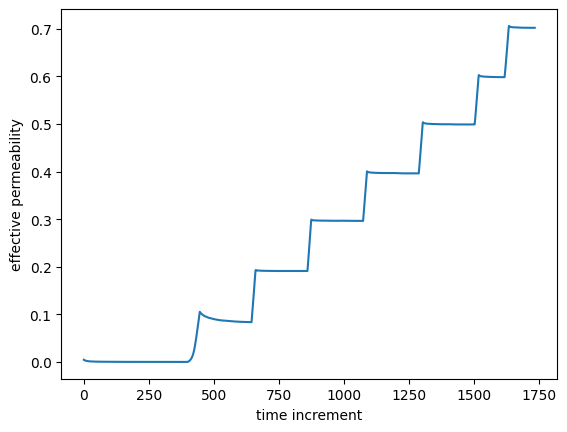

In [14]:
D=pd.read_csv("../lbpm/relperm/castle/timelog.csv",sep=" ")

plt.figure()
plt.plot(D['sw'])
plt.xlabel('time increment')
plt.ylabel('effective permeability')
plt.show()

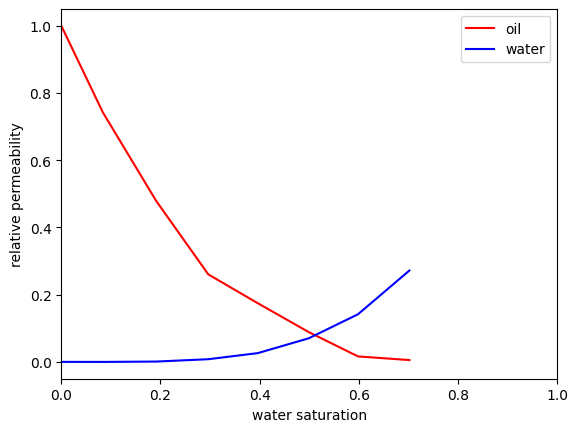

In [15]:
SCAL=pd.read_csv("../lbpm/relperm/castle/SCAL.csv",sep=" ")

# Scale the curve to the far LHS value
k=SCAL['eff.perm.oil.upper.bound'][0]
krn=SCAL['eff.perm.oil.upper.bound']/k
krw=SCAL['eff.perm.water.upper.bound']/k

plt.figure()
plt.plot(SCAL['sat.water'],krn, c='r', label='oil')
plt.plot(SCAL['sat.water'],krw, c='b', label='water')
plt.xlabel('water saturation')
plt.ylabel('relative permeability')
ax = plt.gca()
ax.set_xlim([0,1])
plt.legend()
plt.show()

# Fluid Configurations

The simulator will save 3D outputs for steady-state points

* visualization files in HDF5 format (can be read into Paraview or VisIt)
* 8-bit raw binary files 

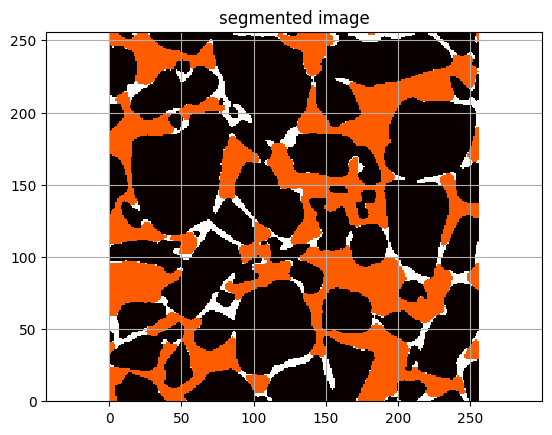

In [12]:
def PlotImage(input_file) :
    ID=tifffile.imread(input_file)
    plt.figure(2)
    plt.title('segmented image')
    plt.pcolormesh(ID[100,:,:],cmap='hot')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    return(ID)

ID=PlotImage("../data/lrc32_Ca1e-4/id_t67000.tif")

# Saturation Profiles

For fractional flow experiments it is desireable to have a relatively constant saturation profile across the sample

LBPM has internal tools to minimize the influence of boundary effects
* mixing layers at the inlet and outlet to minimize "mismatch"
* flow adaptor evenly distributes saturation throughout the image

Read values[0 1 2]
Read counts[10299382  5435817  1042017]
Saturation 0.16085886115636802


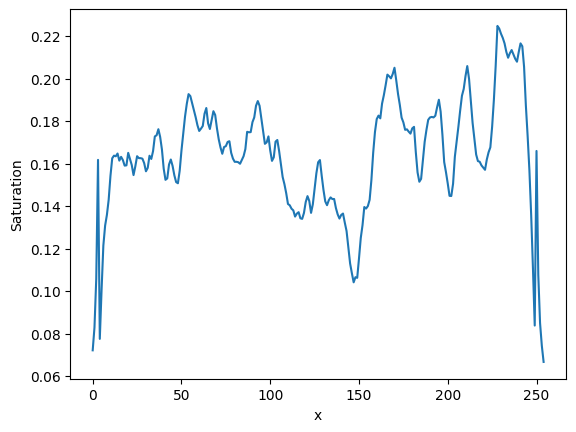

In [9]:
def ComputeSaturationProfile(ID):

  # Load the data
  #ID = np.fromfile(image,dtype = np.uint8)
  #ID.shape = (lz,ly,lx)
  lz = ID.shape[0]
    
  read_values, read_counts = np.unique(ID, return_counts=True)
  value_count = read_values.size
  print("Read values" + str(read_values))
  print("Read counts" + str(read_counts))
  Na = read_counts[1]
  Nb = read_counts[2]
  Sb = Nb/(Na+Nb)
  print("Saturation "+str(Sb))

  result=np.array([])
  for idx in range(1,lz):
    slice = ID[idx,:,:]
    Na = np.count_nonzero(slice == 1)
    Nb = np.count_nonzero(slice == 2)
    Sb = Nb/(Na+Nb)
    result=np.append(result,Sb)

  plt.figure()
  plt.plot(result)
  plt.xlabel('x')
  plt.ylabel('Saturation')
  plt.show()

ComputeSaturationProfile(ID)

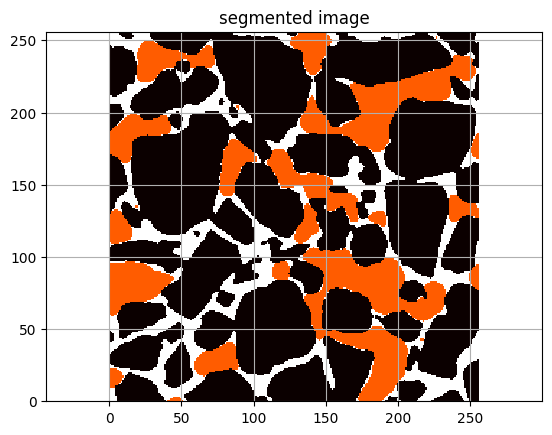

In [10]:
ID=PlotImage("../data/lrc32_Ca1e-4/id_t255000.tif")

Read values[0 1 2]
Read counts[10299382  3684164  2793670]
Saturation 0.43126606825676606


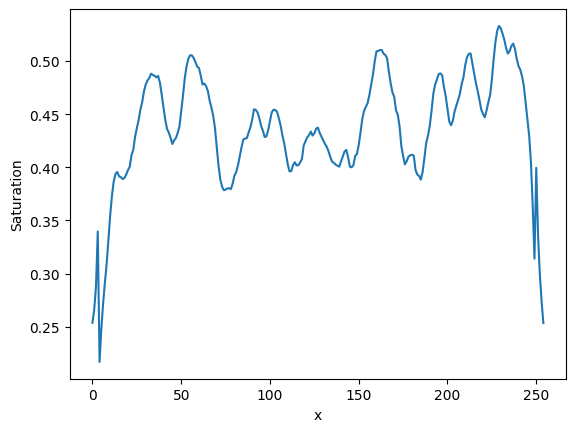

In [11]:
ComputeSaturationProfile(ID)

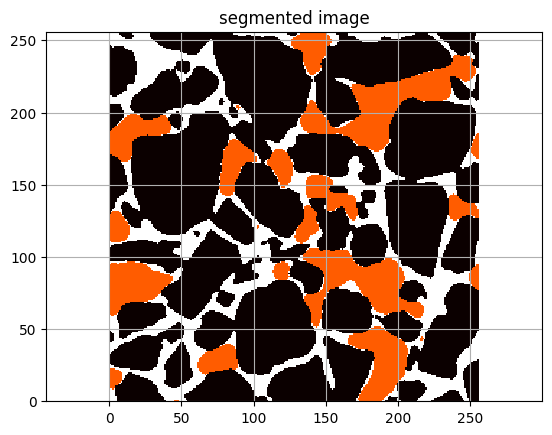

In [12]:
ID=PlotImage("../data/lrc32_Ca1e-4/id_t331000.tif")

Read values[0 1 2]
Read counts[10299382  3017383  3460451]
Saturation 0.5341987769368588


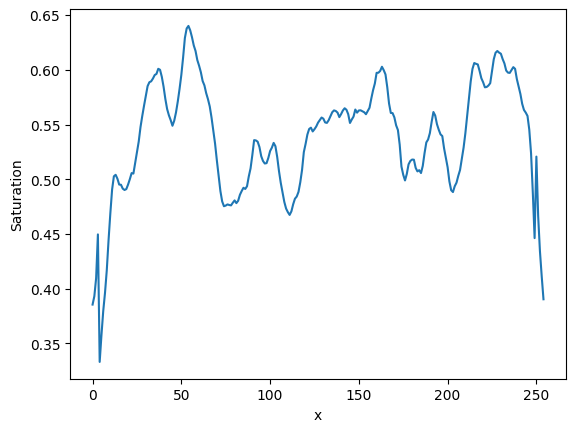

In [13]:

ComputeSaturationProfile(ID)